In [1]:
import os
import sys
# Root folder
sys.path.append("../..")

import numpy as np
from PIL import Image

from apis.detectors import OWLViT
from apis.segmentors import SAM
from apis.language_model import GPT4V


from agents.dom import DOM

from utils.image_utils import annotate_positions_in_image, visualize_image
from utils.masks import Mask

/home/kaixin/anaconda3/envs/dom/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
init_image = Image.open("../assets/images/table_and_cans/two_cans.jpg").resize((480,360))
upper_right_image = Image.open("../assets/images/table_and_cans/upper_right.jpg").resize((480,360))
upper_left_image = Image.open("../assets/images/table_and_cans/upper_left.jpg").resize((480,360))
upper_left_occlusion_image = Image.open("../assets/images/table_and_cans/upper_left_occlusion.jpg").resize((480,360))

In [3]:
segmentor = SAM()
vlm = GPT4V()
detector = OWLViT()
agent = DOM(vlm=vlm, detector=detector, segmentor=segmentor, enable_logging=False)

In [4]:
detected_objects = detector.detect_objects(init_image, text_queries=["can"])
detected_objects

[{'score': 0.6930882334709167,
  'bbox': [0.13876865804195404,
   0.3237127661705017,
   0.23262540996074677,
   0.477376788854599],
  'box_name': 'can'},
 {'score': 0.6755174398422241,
  'bbox': [0.4626842439174652,
   0.5141156911849976,
   0.5374239683151245,
   0.675916314125061],
  'box_name': 'can'}]

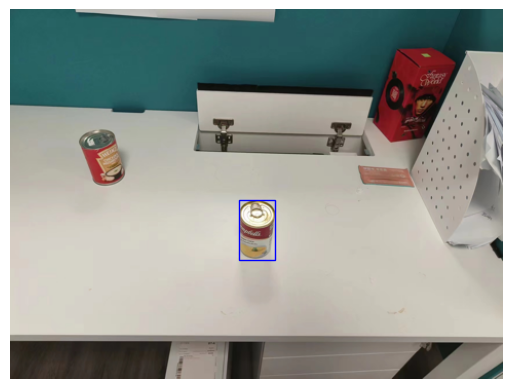

In [5]:
# Select the one in the middle
can = detected_objects[1]

visualize_image(image=init_image, bboxes=[can["bbox"]])

In [6]:

seg_result = segmentor.segment_by_bboxes(init_image, bboxes=[can["bbox"]])[0]
can_mask = Mask(mask=seg_result["segmentation"], name="can", ref_image=init_image)

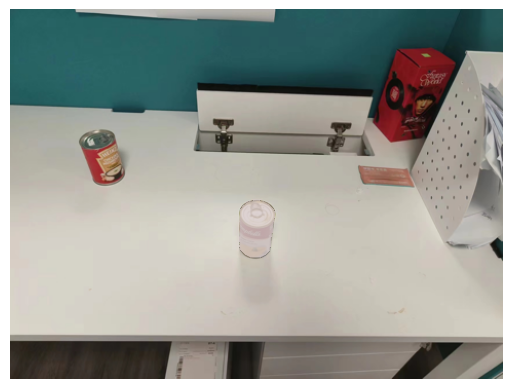

In [7]:
visualize_image(image=init_image, masks=[can_mask.mask])

In [8]:
can_mask.bbox()

(0.46458333333333335,
 0.5166666666666667,
 0.5354166666666667,
 0.6694444444444444)

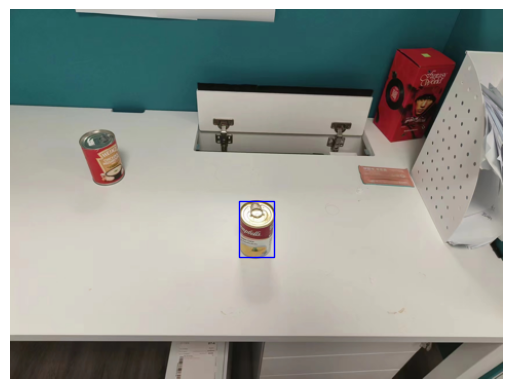

In [9]:
visualize_image(image=init_image, bboxes=[can_mask.bbox()])

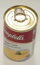

In [10]:
cropped_image, cropped_bbox = can_mask.crop_obj(padding=0.1)
cropped_image

# Re-identification

Place_point: (0.2660691440105438, 0.3855755776166916)


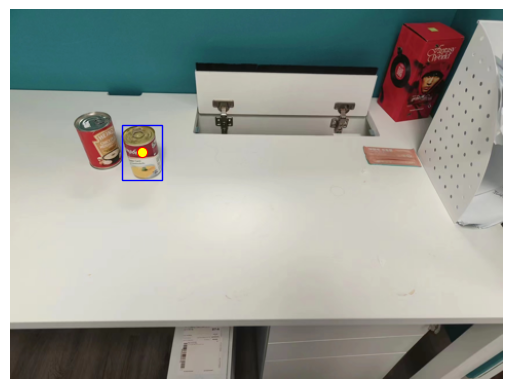

In [12]:
# Select the one in the middle
new_can = new_detected_objects[1]
new_bbox = new_can["bbox"]
place_point = ((new_bbox[0] + new_bbox[2])/2, (new_bbox[1] + new_bbox[3])/2)
print("Place_point:", place_point)

visualize_image(image=upper_left_image, bboxes=[new_can["bbox"]], points=[place_point])

In [13]:
can_mask.reidentify(new_image=upper_left_image, place_point=place_point, detector=detector, segmentor=segmentor)

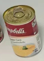

In [16]:
can_mask.crop_obj(padding=0.1)[0]

**Let's try a more difficult one with occlusion.**

In [17]:
can_mask.reidentify(new_image=upper_left_occlusion_image, place_point=place_point, detector=detector, segmentor=segmentor)

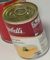

In [19]:
can_mask.crop_obj(padding=0.05)[0]